<a href="https://colab.research.google.com/github/aashishpiitk/from-Scratch/blob/master/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import math

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
### preparing the celebA dataset

% mkdir /content/dataset


In [ ]:
# Root directory for dataset
dataset_path = "/content/dataset/img_align_celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
im_shape = (64,64)

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100 ## nz denotes the number of channels

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
my_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])

dataset = datasets.MNIST(root='/content/dataset', train=True, transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Extracting /content/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /content/dataset/MNIST/raw




Extracting /content/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw




Extracting /content/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/dataset/MNIST/raw




Extracting /content/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw

Processing...
Done!


In [ ]:
len(dataloader)

469

In [ ]:
# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
## Writing my first generator code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.net = nn.Sequential(
        # input is Z (noise vector) going into a transpose convolution
        nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0,bias=False),
        nn.BatchNorm2d(ngf*8),  # batchnorm on 4d input, with one dimension for number of images and one for channels, the first argument is the numner of features
        nn.ReLU(inplace=True),

        # state size ==== (ngf*8) x 4 x 4 ## think of it as applying a conv with kernel=(4x4) with stride 1 on (ngf*8) x 4 x4, then result would be (ngf*8)x1x1
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),

        # state size == (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),

        # state size == (ngf*2) x 16 x 16
        nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # state size == (ngf) x 32 x 32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
    return self.net(input)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
##### Writing my first disciminator
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.net = nn.Sequential(
        # input is (nc) x 64 x 64 with extra first dimension for number of images(batch_size)
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        # state size === (ndf) x 32 x 32
       nn.Conv2d(ndf, ndf*2, 4, 2,1, bias=False),
       nn.BatchNorm2d(ndf*2),
       nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 16 x 16
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 8 x 8
      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 4 x 4
      nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
      # state size is (batch_size, 1, 1, 1)
      nn.Sigmoid() ## as it is case of binary classification
      # final state size is a sigle float value 
    )
    self.output_shape = (1,1,1)

  def forward(self, input):
   return self.net(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# create a generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
######### Now we enter the training part


# initialize BCE loss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# ########## Training loop

# # lists to keep track of the progress

# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

# print("Starting Training Loop")
# # For each epoch
# for epoch in range(num_epochs):
#   #for each batch in dataloader
#   for i, data in enumerate(dataloader, 0):

#   ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))),as we want to detect fake images
#         ###########################
#     ## train with all real batch
#     netD.zero_grad() # initialize all the gradients as zero
#     # format batch
#     real_cpu = data[0].to(device)
#     b_size = real_cpu.size(0) ## batch size
#     label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#     # forward pass real batch through D
#     output = netD(real_cpu).view(-1)
#     # calculate loss on all real batch
#     errD_real = criterion(output, label)
#     # calculate gradients for D in backward pass
#     errD_real.backward()
#     D_x = output.mean().item()

#     ## Train with all-fake batch
#     # generate batch of latent vectors
#     noise = torch.randn(b_size, nz, 1, 1, device=device)
#     # generate fake image with Generator model by passing the random vector
#     fake = netG(noise)
#     label.fill_(fake_label)

#     # classify all fake batch with D
#     output = netD(fake.detach()).view(-1)


In [ ]:
## output of generator would be (batch_size, 3, 218, 178) ---> (batch_size, 3, 64, 64)
## input of generator wouuld be (batch_size, nz, 1, 1)
## input of discriminator is = output of discriminator = (batch_size, 3, 218, 178) ---> (batch_size, 3, 64, 64)
## output of discriminator is ()

In [ ]:
gen_output = netG(torch.randn(64,100,1,1).to(device))

In [ ]:
print(gen_output.shape)

torch.Size([64, 1, 64, 64])


In [ ]:
disc_output = netD(gen_output)

In [ ]:
print(disc_output.shape)

torch.Size([64, 1, 1, 1])


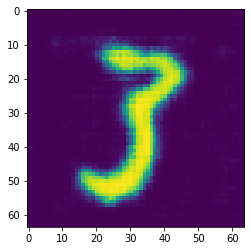

In [ ]:
plt.imshow(gen_output[0].detach().cpu().numpy().transpose(1,2,0).squeeze(2))

In [ ]:
print(disc_output[0])

tensor([[[0.3949]]], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
len(dataloader.dataset)

60000

In [ ]:
######## writing the trainning loop

## Weight initialization
netD.apply(weights_init)
netG.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


train_gen_losses, train_disc_losses, train_counter = [], [], []

for epoch in range(num_epochs):
  gen_loss, disc_loss = 0,0 
  tqdm_bar = (tqdm(dataloader, 
                   desc=f'Training Epoch {epoch}', 
                   total = int(len(dataloader))))

  for batch_idx, (imgs, targets) in enumerate(tqdm_bar):

    netG.train(); netD.train()
    batch_size = imgs.shape[0] ## important step so that there is no error in case the last batch is not of the required size
    real_images = imgs.to(device)
    
    real_labels = torch.full((batch_size,1,1,1), 0.9, dtype=torch.float, device=device)
    fake_labels = torch.full((batch_size,1,1,1), 0.1, dtype=torch.float, device=device)
    
    noise = torch.randn(batch_size, nz, 1, 1,device=device)
    ## Generator
    netG.zero_grad()
    gen_output = netG(noise)
    disc_output = netD(gen_output)

    loss_G = criterion(disc_output, real_labels)
    loss_G.backward()
    optimizerG.step()

    


    ##Discriminator
    netD.zero_grad()
    output_real = netD(real_images)
    D_loss_real = criterion(output_real, real_labels)
    output_fake = netD(gen_output.detach())

    D_loss_fake = criterion(output_fake, fake_labels)
    loss_D = (D_loss_real + D_loss_fake)/2
    loss_D.backward()
    optimizerD.step()
    
    gen_loss += loss_G.item()
    train_gen_losses.append(loss_G.item())
    disc_loss+= loss_D.item()
    train_disc_losses.append(loss_D.item())
    

    train_counter.append(batch_idx*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
    tqdm_bar.set_postfix(gen_loss = gen_loss/(batch_idx+1), disc_loss = disc_loss/(batch_idx+1))


  if(True):
      # torch.save({
      #       'epoch': epoch+1,
      #       'generator_state_dict': generator.state_dict(),
      #       'optimizer_state_dict': optimizer_G.state_dict(),
      #       'loss': loss,
      #       ...
      #       }, PATH)

      # torch.save({
      #       'epoch': epoch+1,
      #       'discriminator_state_dict': discriminator.state_dict(),
      #       'optimizer_state_dict': optimizer.state_dict(),
      #       'loss': loss,
      #       ...
      #       }, PATH)
      torch.save({
            'discriminator_state_dict': netD.state_dict(),
            'generator_state_dict': netG.state_dict(),
            'optimizer_G_state_dict': optimizerG.state_dict(),
            'optimizer_D_state_dict': optimizerD.state_dict(),
            'epoch': epoch+1,
            }, "/content/drive/MyDrive/MNIST_data/checkpt{}.pt".format(epoch+1))


KeyboardInterrupt: ignored

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
##fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                        ## marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
#fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
 #                        marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

In [ ]:
gen_output = netG(torch.randn(64,100,1,1).to(device))

In [ ]:
print(gen_output.shape)

torch.Size([64, 1, 64, 64])


In [ ]:
disc_output = netD(gen_output)

In [ ]:
print(disc_output.shape)

torch.Size([64, 1, 1, 1])


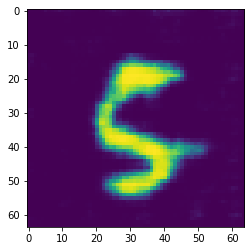

In [ ]:
plt.imshow(gen_output[0].detach().cpu().numpy().transpose(1,2,0).squeeze(2))

In [ ]:
print(disc_output[0])

tensor([[[0.3949]]], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save({
            'discriminator_state_dict': netD.state_dict(),
            'generator_state_dict': netG.state_dict(),
            'optimizer_G_state_dict': optimizerG.state_dict(),
            'optimizer_D_state_dict': optimizerD.state_dict(),
            'epoch': epoch+1,
            }, "/content/drive/MyDrive/MNIST_data/checkpt{}.pt".format(2))

In [ ]:
% cd /content/dataset/img_align_celeba
% ls

In [ ]:
### inspecting the image properties of celebA dataset

from PIL import Image

im_temp = Image.open("/content/dataset/img_align_celeba/033275.jpg")
trans1 = transforms.ToTensor()
trans2 = transforms.Compose([
                                            transforms.Resize((im_height,im_width)),
                                            transforms.CenterCrop((im_shape)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean,std)
    ])
print(trans2(im_temp).shape)
plt.imshow(trans2(im_temp))